## **Digital Attribution Analysis at W.M. Winters📊**


## **Overview**

**Load libraries**

In [ ]:
# Install & load packages
!pip install openpyxl

import pandas as pd
import warnings
import numpy as np
from datetime import datetime

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

**Exploring Dataset**

In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BA860 Marketing Analytics/Winters-Attribution-PS3-MSBA-2023.csv')
df = df.iloc[:, 1:]
display(df.head())
display(df.info())
display(df.describe())

,Orderid,Orderdatetime,Saleamount,Newcustomer,Position,Positiondatetime,Groupname,Networkname,Networkid,Brand,Positionname,DaysToConvert
0,11634052,2012-05-01 4:24,341.5,Y,1,2012-05-01 3:49,BUZZ AFFILIATE,Buzz CPA Affiliate,buzz23,N,CONVERTER,0
1,11634052,2012-05-01 4:24,341.5,Y,0,2012-05-01 3:47,SEARCH GOOGLE BRAND,G: Medifast Brand Terms > Medifast >,g000793,Y,ORIGINATOR,0
2,11634059,2012-05-01 4:08,339.0,Y,2,2012-04-29 21:01,PRINT - MAGAZINES,Medifastok.com,medifastok.com,N,CONVERTER,2
3,11634059,2012-05-01 4:08,339.0,Y,1,2012-04-24 5:29,CPM,Armonix,nar7467,N,ASSIST,7
4,11634059,2012-05-01 4:08,339.0,Y,0,2012-04-23 2:46,PRINT - MAGAZINES,Medifastok.com,medifastok.com,N,ORIGINATOR,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7652 entries, 0 to 7651
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Orderid           7652 non-null   int64  
 1   Orderdatetime     7652 non-null   object 
 2   Saleamount        7652 non-null   float64
 3   Newcustomer       7652 non-null   object 
 4   Position          7652 non-null   int64  
 5   Positiondatetime  7652 non-null   object 
 6   Groupname         7652 non-null   object 
 7   Networkname       7652 non-null   object 
 8   Networkid         7652 non-null   object 
 9   Brand             7596 non-null   object 
 10  Positionname      7652 non-null   object 
 11  DaysToConvert     7652 non-null   int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 717.5+ KB


None

,Orderid,Saleamount,Position,DaysToConvert
count,7.652000e+03,7652.000000,7652.000000,7652.000000
mean,1.170133e+07,237.073020,2.412180,12.047961
std,3.892396e+04,118.993368,2.155684,29.136394
min,1.163405e+07,19.090000,0.000000,0.000000
25%,1.166653e+07,159.190000,1.000000,0.000000
50%,1.170200e+07,241.315000,2.000000,0.000000
75%,1.172963e+07,324.950000,4.000000,7.000000
max,1.177750e+07,1402.090000,9.000000,198.000000


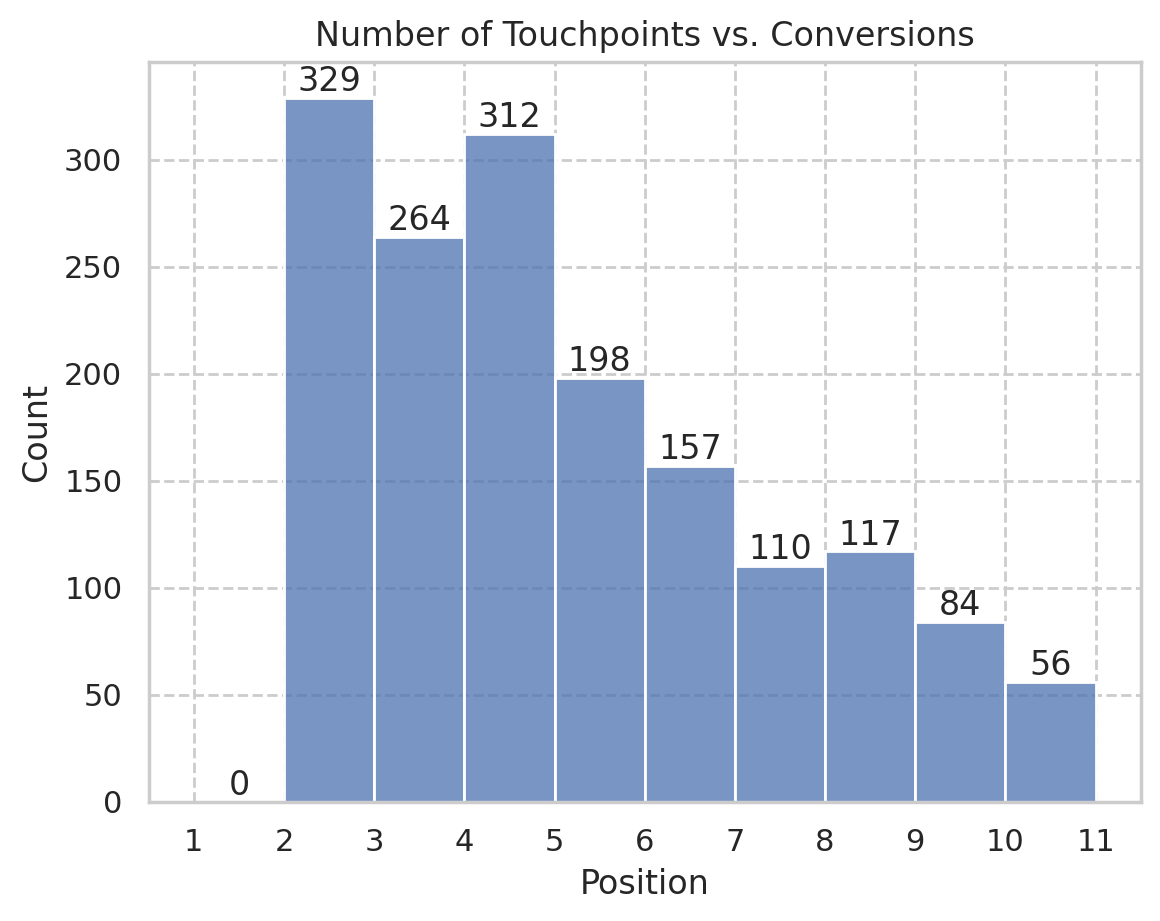

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

Touch = df.loc[df['Positionname']=='CONVERTER', 'Position']+1
sns.histplot(Touch, bins = range(1,12))
plt.xticks(range(1, 12, 1))
plt.title("Number of Touchpoints vs. Conversions")

for rect in plt.gca().patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height, f'{height:.0f}', ha='center', va='bottom')

plt.show()

- From the histogram, minimum number of touchpoints is 2 based on the last-touchpoint model, which measures converters. 329 conversions happened with only 2 touchpoints, while 56 conversions happened with 11 touchpoints.

In [ ]:
counts = df['Groupname'].value_counts().sort_values(ascending=False)
counts

CPM                        4483
BUZZ AFFILIATE             1336
SEARCH GOOGLE BRAND         809
CJ                          545
SEARCH MSN BRAND            178
SEARCH GOOGLE NON-BRAND     105
Uncategorized                71
TV                           49
OTHER                        40
SEARCH MSN NON-BRAND         16
PRINT - MAGAZINES            14
SEARCH YAHOO BRAND            3
Social                        2
DIRECT MAIL                   1
Name: Groupname, dtype: int64

## **1. Compare first-touch vs. last-touch attribution models**

- a) What is the number of orders attributed to each channel using a last-touch model? What about the number of orders attributed to each channel using a first-touch model? What is the corresponding share of credit from the two attribution models?

In [ ]:
# Last-touch model
# last-touchpoint uses CONVERTER, grouped by channel names
last = df[df['Positionname'] == 'CONVERTER'].groupby(['Groupname'])['Orderid'].nunique().reset_index().rename(columns={'Orderid': 'Converter_orders'})
last['Converter_credit'] = last['Converter_orders']*100/ last['Converter_orders'].sum()

# First-touch model
# first-touchpoint uses ORIGINATOR
first = df[df['Positionname'] == 'ORIGINATOR'].groupby(['Groupname'])['Orderid'].nunique().reset_index().rename(columns={'Orderid': 'Originator_orders'})
first['Originator_credit'] = first['Originator_orders']*100/ first['Originator_orders'].sum()

# merging 2 dataframes
results = pd.concat([last.set_index('Groupname'), first.set_index('Groupname')], axis=1)
results = results[['Converter_orders', 'Originator_orders', 'Converter_credit', 'Originator_credit']]
total_row = pd.DataFrame(results.sum(axis=0), columns=['Total']).T

# Concatenating 2 model results
results = pd.concat([results, total_row], axis=0)
results = results.round(2)
results.index.name = None
results.index.name = 'Marketing Channels'
results = results.reset_index()

results

,Marketing Channels,Converter_orders,Originator_orders,Converter_credit,Originator_credit
0,BUZZ AFFILIATE,468.0,215.0,28.76,13.21
1,CJ,234.0,83.0,14.38,5.10
2,CPM,834.0,602.0,51.26,37.00
3,OTHER,4.0,20.0,0.25,1.23
4,PRINT - MAGAZINES,5.0,4.0,0.31,0.25
5,SEARCH GOOGLE NON-BRAND,34.0,48.0,2.09,2.95
6,SEARCH MSN NON-BRAND,7.0,5.0,0.43,0.31
7,TV,16.0,16.0,0.98,0.98
8,Uncategorized,25.0,12.0,1.54,0.74
9,DIRECT MAIL,NaN,1.0,NaN,0.06


**1. b) In a single bar chart, plot the share of credit (in percentage) for the first- and last- touch attribution models by marketing channel.**

In [ ]:
# create a subset of the above results df for plotting
subset = results.iloc[0:-1, :]
subset

,Marketing Channels,Converter_orders,Originator_orders,Converter_credit,Originator_credit
0,BUZZ AFFILIATE,468.0,215.0,28.76,13.21
1,CJ,234.0,83.0,14.38,5.10
2,CPM,834.0,602.0,51.26,37.00
3,OTHER,4.0,20.0,0.25,1.23
4,PRINT - MAGAZINES,5.0,4.0,0.31,0.25
5,SEARCH GOOGLE NON-BRAND,34.0,48.0,2.09,2.95
6,SEARCH MSN NON-BRAND,7.0,5.0,0.43,0.31
7,TV,16.0,16.0,0.98,0.98
8,Uncategorized,25.0,12.0,1.54,0.74
9,DIRECT MAIL,NaN,1.0,NaN,0.06


<Figure size 1600x500 with 0 Axes>

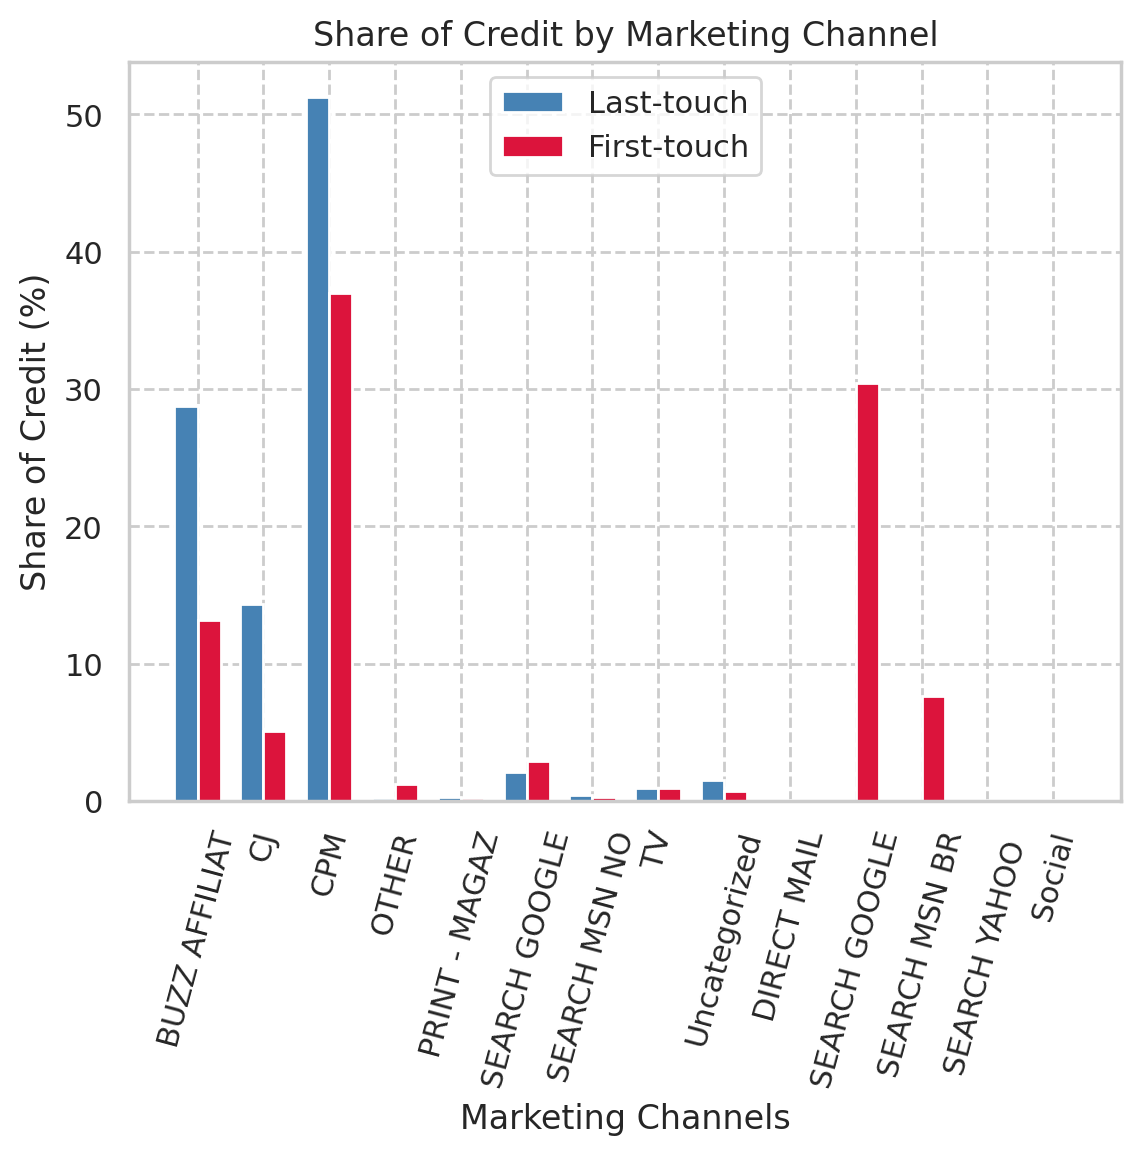

In [ ]:
plt.figure(figsize=(16, 5))
# create two bins for each touchpoint model
n = len(subset['Marketing Channels'])
width = 0.35
x = np.arange(n)
fig, ax = plt.subplots()
last_touch = ax.bar(x - width/2, subset['Converter_credit'], width, color='steelblue', label='Last-touch')
first_touch = ax.bar(x + width/2, subset['Originator_credit'], width, color='crimson', label='First-touch')

plt.title('Share of Credit by Marketing Channel')
plt.xlabel('Marketing Channels')
plt.ylabel('Share of Credit (%)')
plt.xticks(x, [label[:13] for label in subset['Marketing Channels']], rotation=75)
plt.legend()
plt.show()

- **Observation:** Based on the single bar chart, we see large variations in share of channel credits among `BUZZ AFFILIATE`, `CJ`, and `CPM`. All these 3 channels generated significantly higher share of credits (%) in the last-touchpoint model which assigns 100% of credits to the last touchpoint associated with conversions. This means these channels are mostly frequented by users just before they make purchases.

- However, for first-touchpoint model, we see `BUZZ AFFILIATE`, `CPM`, and `SEARCH GOOGLE BRAND` having high shares of credits. **In particular, both Google searches and MSN searches have high shares of credits in the first-touchpoint model, whereas the last-touchpoint model assigns 0% to both.** This is because search engines typically tend to be the starting point of product search journys for most users.

**1. c) Compare results from the two attribution model. What would be the consequence to Winters if it allocated its marketing budget entirely based on the last-touch attribution model?**

- **Search engines clearly presents a significant edge in first-touch attribution model** since that's where customers start their purchase/conversion journey. If Winters only allocate budgets based on the last-touch attribution model, then it will have a much smaller customer size in the beginning (there's no search engine to advertise).
- **Allocating more budgets to affiliate marketing channels makes more sense in later stages of the consumer journey** since the bar chart suggests that they generated much higher shares of credits based on the last-touch attribution model.

## **2. Compare new and old customers**
- a) What is the average number of days that it takes for a new customer to convert (from the first touchpoint)? What is the average number of days that it takes for an old customer to convert?

In [ ]:
df.head()

,Orderid,Orderdatetime,Saleamount,Newcustomer,Position,Positiondatetime,Groupname,Networkname,Networkid,Brand,Positionname,DaysToConvert
0,11634052,2012-05-01 4:24,341.5,Y,1,2012-05-01 3:49,BUZZ AFFILIATE,Buzz CPA Affiliate,buzz23,N,CONVERTER,0
1,11634052,2012-05-01 4:24,341.5,Y,0,2012-05-01 3:47,SEARCH GOOGLE BRAND,G: Medifast Brand Terms > Medifast >,g000793,Y,ORIGINATOR,0
2,11634059,2012-05-01 4:08,339.0,Y,2,2012-04-29 21:01,PRINT - MAGAZINES,Medifastok.com,medifastok.com,N,CONVERTER,2
3,11634059,2012-05-01 4:08,339.0,Y,1,2012-04-24 5:29,CPM,Armonix,nar7467,N,ASSIST,7
4,11634059,2012-05-01 4:08,339.0,Y,0,2012-04-23 2:46,PRINT - MAGAZINES,Medifastok.com,medifastok.com,N,ORIGINATOR,8


In [ ]:
# group by 'Newcustomer' and 'avg_convert'
avg_convert = round(df.groupby(['Newcustomer', 'Position'])['DaysToConvert'].agg('mean'),2).reset_index()
# filter the avg_convert to only include 1st touches
avg_convert = avg_convert.loc[avg_convert['Position']==0, ['Newcustomer', 'DaysToConvert']]
#rename the 'DaysToConvert' column to 'AvgDaysToConvert'
avg_convert = avg_convert.rename(columns={'DaysToConvert': 'Avg Days'})
avg_convert

,Newcustomer,Avg Days
0,N,30.98
10,Y,5.44


- Dataframe is grouped on `Newcustomer` and average number of days to convert. Old customers typically take 30.98 days to convert, while new customers only take 5.44 days to convert. Both results are based on the first-touch attribution model where `Position == 0`.

**2. b) What is the average number of touchpoints by new versus old customer’s orders?
Hint: Use the Touches variable if available. If not, create the ‘Touches’ variable for the number of
touchpoints per order.**

In [ ]:
# create a touches variable that sums up total touchpoints per orderid
df['touches']=df.groupby('Orderid')['Position'].transform('count')
# drop duplicate rows based on 'Orderid'
df_unique = df.drop_duplicates(subset='Orderid')
# calculate the average number of touchpoints by new versus old customer's orders
avg_touches = df_unique.groupby('Newcustomer')['touches'].mean().round(2).reset_index()
avg_touches = avg_touches.rename(columns={'touches': 'Avg Touches'})
avg_touches

,Newcustomer,Avg Touches
0,N,5.24
1,Y,4.33


- Avg number of touchpoints by new customers (=Y) is around 4.33, while by old customers is 5.24. Old users exhibited higher number of touchpoints on average.

**2. c) What is the average order sales amount by new versus old customer’s orders?**

In [ ]:
from scipy.stats import ttest_ind

avg_sale = df.groupby(['Saleamount', 'Newcustomer', 'Orderid']).agg({'Saleamount': 'mean'})
# group df by Newcustomer and calculate sales mean
avg_sale = round(avg_sale.groupby('Newcustomer').mean(), 2).reset_index()
avg_sale = avg_sale.rename(columns={'Saleamount': 'Avg Sales'})
display(avg_sale)

# #perform t.test on avg sales of users
# df_test = df.groupby(['Saleamount', 'Newcustomer', 'Orderid']).agg({'Saleamount': 'mean'})
# newsale = df_test.loc[(slice(None), 'Y'), 'Saleamount']
# oldsale = df_test.loc[(slice(None), 'N'), 'Saleamount']
# t_stat, p_value = ttest_ind(newsale, oldsale, equal_var=False)
# print('t-statistic is:', round(t_stat,2))
# print('p-value is:', p_value)

,Newcustomer,Avg Sales
0,N,205.60
1,Y,268.57


- Avg sales is \$205.6 for old customers and \$268.57 for new customers. This means new customers bring in more revenue per order on average.

**2. d) Summarize how new and old customers differ along these three variables.**

- Old users on average take significantly more days (30.98 days) to convert compared to new users (5.44 days).

- Old users on average have more touchpoints (5.24) compared to new users (4.33).

- Avg sales for old users is \$205.6, while for new users is relatively higher at \$268.57. The average sales difference is statistically significant.

## **3. Consider the revenue per marketing channel using first-touch attribution.**
- a) Create a table (as in Q1) containing the average sales per order as well as the total revenue by originator channel.

In [ ]:
# Position=0 if using first-touchpoint model
firsttouch = round(df[df['Position'] == 0].groupby('Groupname').agg({'Saleamount': ['mean', 'sum']}), 2).rename(columns={'mean': 'Avg Sales', 'sum': 'Total Sales'})
firsttouch = firsttouch.reset_index()
display(firsttouch)

Groupname Saleamount            
                             Avg Sales Total Sales
0            BUZZ AFFILIATE     256.13    55068.89
1                        CJ     248.92    20660.03
2                       CPM     237.25   142822.39
3               DIRECT MAIL     170.98      170.98
4                     OTHER     243.17     4863.34
5         PRINT - MAGAZINES     262.98     1051.91
6       SEARCH GOOGLE BRAND     248.82   123167.78
7   SEARCH GOOGLE NON-BRAND     236.50    11351.95
8          SEARCH MSN BRAND     230.88    28629.47
9      SEARCH MSN NON-BRAND     216.30     1081.49
10       SEARCH YAHOO BRAND     258.49      258.49
11                   Social     165.00      165.00
12                       TV     218.47     3495.47
13            Uncategorized     186.48     2237.76

**3. b) What is the total incremental net revenue accruing to Winters by originator channel? Express your answer in a table. Assume that Winters has a gross margin of 40%. Also assume 5% of sales from branded search are incremental, and 10% sales are incremental for the remaining channels.**

In [ ]:
#filter results based on originator channels w/ Position=0
orig_channel = df[df['Position'] == 0]

#incremental revenue, groupby channels
#seperate branded search and non-branded searches based on 'N' and 'Y'
orig_channel['Increment_rev'] = orig_channel.apply(lambda row:
                                                 row['Saleamount']*0.1 if row['Brand'] == 'N'
                                                 else row['Saleamount']*0.05,
                                                 axis=1)
#incremental net revenue = incremental revenue*0.4
orig_channel['Incremental_net'] = orig_channel['Increment_rev']*0.4

#total incremental net revenue by Originator channels
orig_net_rev = round(orig_channel.groupby('Groupname').agg({'Incremental_net': 'sum'}),2)
orig_net_rev.index.name = 'Originator Channel'
orig_net_rev.columns = ["Incremental Net Revenue"]
orig_net_rev = orig_net_rev.sort_values(by='Incremental Net Revenue', ascending=False).reset_index()
orig_net_rev

,Originator Channel,Incremental Net Revenue
0,CPM,5712.90
1,SEARCH GOOGLE BRAND,2463.36
2,BUZZ AFFILIATE,2202.76
3,CJ,826.40
4,SEARCH MSN BRAND,572.59
5,SEARCH GOOGLE NON-BRAND,454.08
6,OTHER,115.00
7,Uncategorized,89.51
8,TV,69.91
9,SEARCH MSN NON-BRAND,43.26


- **Total incremental net revenue** accruing to Winters by originator channel is the highest for `CPM` and `SEARCH GOOGLE BRAND`, which makes sense since display ads and search engines are usually where customers start their purchase journey. The highest incremental net revenue is \$5712.9 from `CPM`.

**3. c) If just found out that Winters search ad team spent $4,200 on branded search advertising during the time period in the data. What is the advice to the search team based on the calculation above?**

In [ ]:
brand_search = round(df.groupby(['Groupname'])['Brand'].value_counts(normalize=True), 2).reset_index(name='Percent')
brand_search = brand_search.rename(columns={'Groupname': 'Channels', 'Brand': 'Branded (Y/N)'})
brand_search = brand_search[['Channels', 'Branded (Y/N)', 'Percent']]
brand_search

,Channels,Branded (Y/N),Percent
0,BUZZ AFFILIATE,N,1.00
1,CJ,N,1.00
2,CPM,N,1.00
3,OTHER,Y,0.68
4,OTHER,N,0.32
5,PRINT - MAGAZINES,N,1.00
6,SEARCH GOOGLE BRAND,Y,1.00
7,SEARCH GOOGLE NON-BRAND,N,1.00
8,SEARCH MSN BRAND,Y,1.00
9,SEARCH MSN NON-BRAND,N,1.00


In [ ]:
#total incremental net revenue from branded searches
brand_incre = 2463.36+572.59+5.17+115
print(f'Total incremental net revenue from branded searches: ${brand_incre:.2f}')

branded_roi = (brand_incre - 4200) / 4200
print(f'ROI of branded searches: {branded_roi:.4f}')

Total incremental net revenue from branded searches: $3156.12
ROI of branded searches: -0.2485


**3. c) If just found out that Winters search ad team spent $4,200 on branded search advertising during the time period in the data. What is the advice to the search team based on the calculation above?**


**ROI = (Incremental Revenue - Ad Cost)/Ad Cost = (3156.12-4200)/4200 = -24.85%**

- Advice: As shown, the $ROI$ of **branded searches** is rather negative (-24.85%) and suggests the ineffectiveness of branded search. Non-branded channels like `CPM` contributes the highest incremental net revenue of 5712.9.
    - The large gap between `CPM` and search engines suggests that non-branded searches bring in more revenue for the company. **We advise the ad team to spend less budget in brnaded searches due to its negative $ROI$.**

## **4. Linear/uniform attribution:**

*The linear attribution model divides the attribution share between touches equally. For example, an order with one CPM, one CJ, and one TV touchpoint will have place one third attribution share on each touch. This can be accomplished by using the `Touches` variable (see Q2) to define a new variable:*

$$Linear \ Attribution \ Share = 1 / Touches$$

**4. a) For each channel, what is the sum of the linear attribution shares? What is the corresponding share of credit (in percentage) according to the linear attribution model?**

In [ ]:
#def linear share
df['linear_share']=1/df['touches']

#linear_model
linear = df.groupby(['Groupname'])['linear_share'].agg(Linear_share_sum='sum').reset_index()
linear['Linear_credit'] = linear['Linear_share_sum']*100/ linear['Linear_share_sum'].sum()

#create table
results = linear.round(2)
results

,Groupname,Linear_share_sum,Linear_credit
0,BUZZ AFFILIATE,322.69,19.83
1,CJ,136.53,8.39
2,CPM,835.33,51.34
3,DIRECT MAIL,0.33,0.02
4,OTHER,8.19,0.50
5,PRINT - MAGAZINES,3.45,0.21
6,SEARCH GOOGLE BRAND,204.05,12.54
7,SEARCH GOOGLE NON-BRAND,30.58,1.88
8,SEARCH MSN BRAND,48.22,2.96
9,SEARCH MSN NON-BRAND,5.41,0.33


**4. b) Plot the share of credit (in %) for all three attribution models: first-touch, last-touch and linear.**

<Figure size 1600x2000 with 0 Axes>

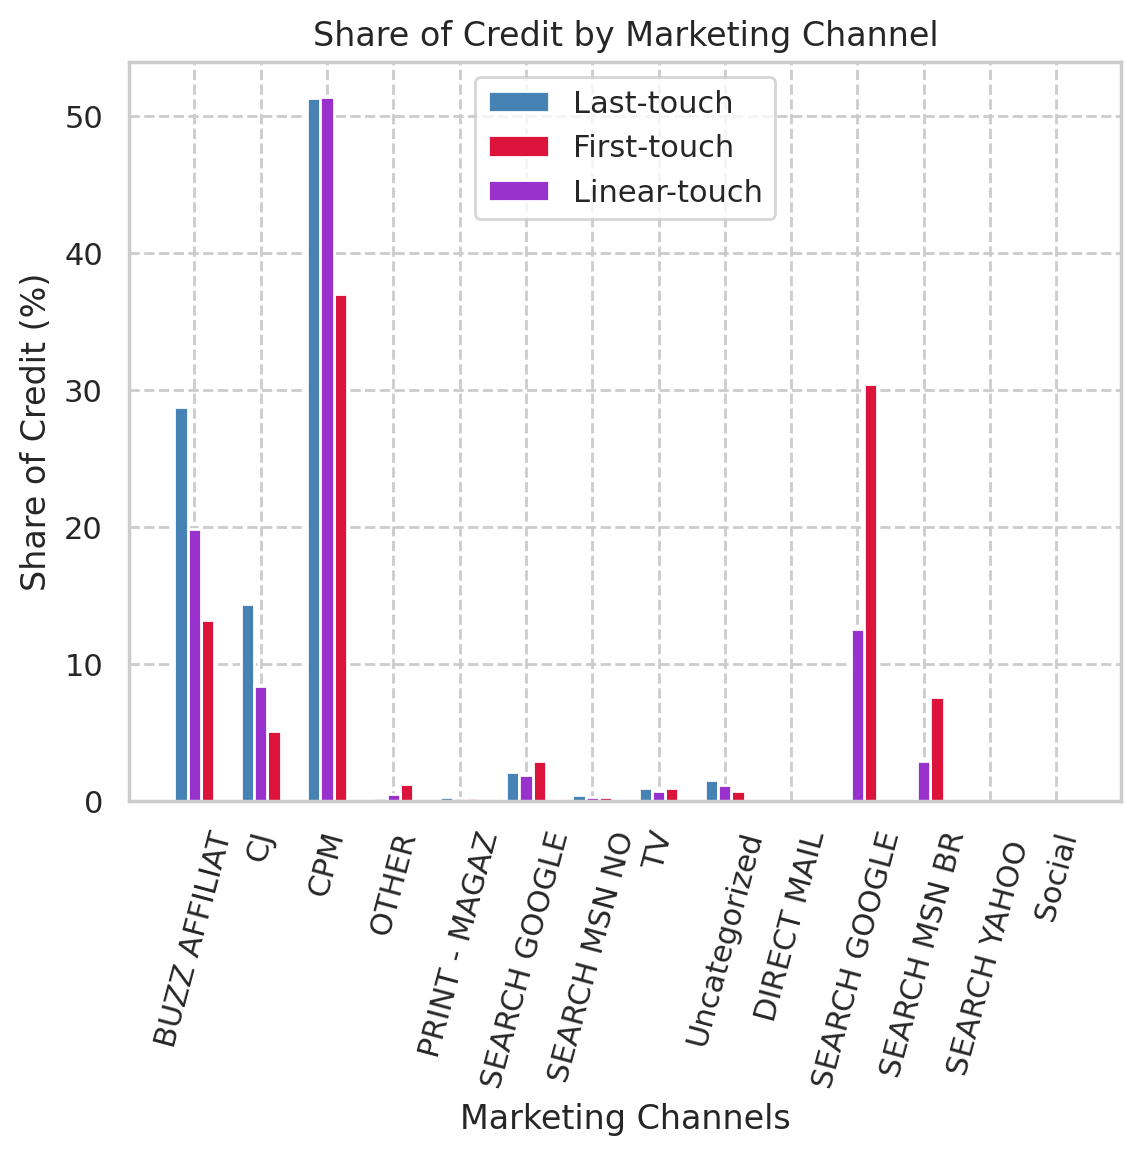

In [ ]:
# merging three channel credit dataset
results = pd.concat([last.set_index('Groupname'), first.set_index('Groupname'), linear.set_index('Groupname')], axis=1)
results = results[['Converter_orders', 'Originator_orders', 'Linear_share_sum', 'Converter_credit', 'Originator_credit', 'Linear_credit']]
total_row = pd.DataFrame(results.sum(axis=0), columns=['Total']).T

# draw bar chart
plt.figure(figsize=(16, 20))
# create three bins for each touchpoint model
n = len(results)
width = 0.2
x = np.arange(n)
fig, ax = plt.subplots()
last_touch = ax.bar(x - width, results['Converter_credit'], width, color='steelblue', label='Last-touch')
first_touch = ax.bar(x + width, results['Originator_credit'], width, color='crimson', label='First-touch')
linear_touch = ax.bar(x, results['Linear_credit'], width, color='darkorchid', label='Linear-touch')

plt.title('Share of Credit by Marketing Channel')
plt.xlabel('Marketing Channels')
plt.ylabel('Share of Credit (%)')
plt.xticks(x, [label[:13] for label in results.index], rotation=75)
plt.legend()
plt.show()

**4. c) Compare the linear model to the first-touch and last-touch models.**

The bar chart shows that `BUZZ AFFILIATE`, `CPM`, and `CJ` maintain high credit share in all three models. The linear model, which distributes equal credit to each touch point, typically assigns credit shares that fall between those of the first and last models. Additionally, the linear model can account for the neglect of the search engine's significance in the last-touch model.

## **5. Examine the role of the intermediate (Roster and Assist) touch points.**

**5.a) (10 pts) Focusing on the top channels, what is the proportion of each channel’s touchpoints by position name: 1) Originator, 2) Roster, 3) Assist, and 4) Converter. Show your result using a table like the following (with the exact top channels listed below):**

<img src="https://user-images.githubusercontent.com/94079366/235006064-c740aff2-0ffc-412f-a22f-e54185545ac3.png" width=500/>

In [ ]:
# count order
count = df.groupby(['Groupname', 'Positionname'])['Orderid'].count().reset_index(name='Count')
# percentage
count['Percentage'] = count.groupby('Groupname')['Count'].apply(lambda x: x / x.sum() * 100)
# sum percentage
sum_percentage = count.groupby('Groupname')['Percentage'].sum().reset_index(name='Total')
# Pivot
pivot_table = count.pivot(index='Groupname', columns='Positionname', values='Percentage')
# Join the sum percentage to the pivot table
pivot_table = pivot_table.join(sum_percentage.set_index('Groupname'))
pivot_table = pivot_table[['ORIGINATOR', 'ROSTER', 'ASSIST', 'CONVERTER','Total']]
pivot_table = pivot_table.reindex(['BUZZ AFFILIATE','CJ','CPM','SEARCH GOOGLE BRAND','SEARCH GOOGLE NON-BRAND','SEARCH MSN BRAND','TV'])
pivot_table.round(2)

,ORIGINATOR,ROSTER,ASSIST,CONVERTER,Total
Groupname,,,,,
BUZZ AFFILIATE,16.09,30.76,18.11,35.03,100.0
CJ,15.23,24.40,17.43,42.94,100.0
CPM,13.43,49.61,18.36,18.60,100.0
SEARCH GOOGLE BRAND,61.19,26.95,11.87,NaN,100.0
SEARCH GOOGLE NON-BRAND,45.71,14.29,7.62,32.38,100.0
SEARCH MSN BRAND,69.66,24.16,6.18,NaN,100.0
TV,32.65,24.49,10.20,32.65,100.0


**5. b) Plot the share in percentage (y-axis) of touchpoint types**

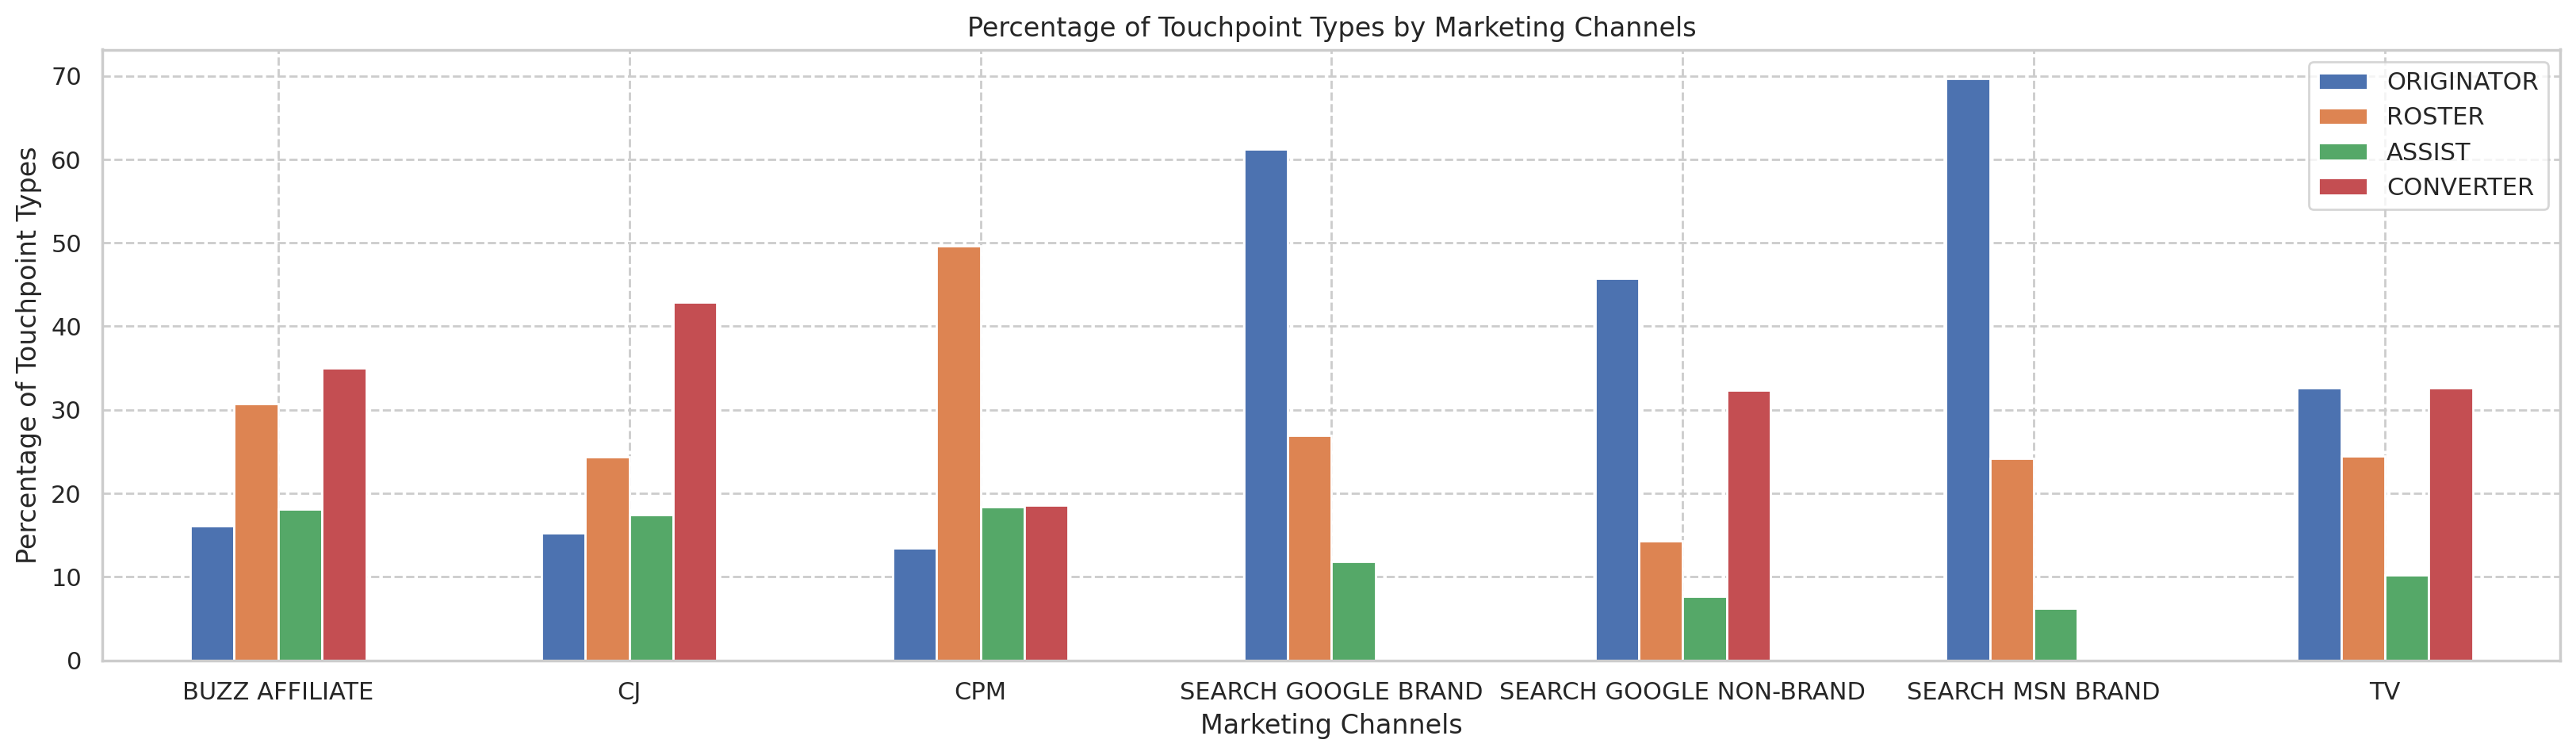

In [ ]:
p=pivot_table.iloc[:, :-1].plot.bar(rot=0, figsize=(20, 5))

# set the axis labels and title
p.set_xlabel('Marketing Channels')
p.set_ylabel('Percentage of Touchpoint Types')
p.set_title('Percentage of Touchpoint Types by Marketing Channels')

# show the plot
plt.show()

**5. c) Summarize the touch-point type results. Which channels seem to have relatively more or less of its touchpoints as rosters and assist? Compared with linear attribution, which of these channels would receive too much or too little credit under first- and last- touch attribution?**



*  The channels with relatively more "ROSTERS" as touchpoints are `CPM` and `BUZZ AFFILIATE` , same as the results for  channels with relatively more "ASSISTS".

*  It is worth noting that `SEARCH GOOGLE NON-BRAND` has relatively lower shares for both "ROSTERS" and "ASSISTS". Similarly, `SEARCH MSN BRAND` has a low share of only 6.47% in "ASSISTS". This is not surprising, as the lower share touchpoints for "ASSISTS" is mostly search engines, which usually occur in the first stage of the customer journey.

*  Compared with linear attribution, search engine channels such as `SEARCH GOOGLE BRAND`, `SEARCH GOOGLE NON-BRAND`, and `SEARCH MSN BRAND` have a large percentage of touchpoints happening in the "ORIGINATOR" stage. This is beneficial when using the first-touch model, as these channels would receive more credit than they would under a linear model. As for the last-touch model, channels that have a higher percentage of touchpoints in the "CONVERTER" stage would receive too much credit. In this case, `BUZZ AFFILIATE` and `CJ` have relatively high share in "CONVERTER" with 35.03% and 42.94%, respectively. On the other hand, channels with a lower percentage of touchpoints in the "CONVERTER" stage, such as `CPM`, may receive too little credit.

In [ ]:
!apt-get install texlive-xetex
! cp "./drive/MyDrive/Colab Notebooks/BA860 Marketing Analytics/BA860_Assignment3_Attribution.ipynb" ./
! jupyter nbconvert --to pdf --no-input BA860_Assignment3_Attribution.ipynb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-xetex is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
[NbConvertApp] Converting notebook BA860_Assignment3_Attribution.ipynb to pdf
[NbConvertApp] Support files will be in BA860_Assignment3_Attribution_files/
[NbConvertApp] Making directory ./BA860_Assignment3_Attribution_files
[NbConvertApp] Making directory ./BA860_Assignment3_Attribution_files
[NbConvertApp] Making directory ./BA860_Assignment3_Attribution_files
[NbConvertApp] Making directory ./BA860_Assignment3_Attribution_files
[NbConvertApp] Writing 48392 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully cr